# CS523 - Applied AI Project
- URL: http://web.eecs.utk.edu/~acw/teaching/f21/cosc423/project.html

## Pathway #2: AI as an Application:
Building machine learning models for a particular domain setting and evaluating them appropriately, e.g. predicting /r/AITA votes with data from Reddit. Projects in this pathway should:
1. Find or collect a dataset for machine learning use.
2. Implement and train models with the dataset, i.e. with scikit-learn or Keras.
3. Design an evaluation that compares the performance of multiple models.

In [51]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 1. Introduction:
- Describe why your project matters.

# 2. Approach:
- Describe your approach.

In [1]:
from math import ceil
from art import *
from matplotlib import pyplot as plt
from IPython.core.display import display
from os import listdir
from os.path import isfile, join, basename
import numpy as np
import pandas as pd
import sys
import tensorflow as tf


# 3. Implementation:
- Describe your approach.


In [2]:
# gpus = tf.config.list_physical_devices('GPU')
# for gpu_instance in gpus:
#     tf.config.experimental.set_memory_growth(gpu_instance, True)


def print_info():
    print('=' * 80)
    print('Python: ' + sys.version)
    print()

    print("# Tensorflow:")
    print('\t* TensorFlow version: {version}'.format(version=tf.__version__))
    print('\t* Eager mode enabled: {mode}'.format(mode=tf.executing_eagerly()))
    print()

    cpus = tf.config.list_physical_devices('GPU')
    gpus = tf.config.list_physical_devices('GPU')

    print("# Devices:")
    print(f"\t* {len(cpus)} CPU(s):")
    print(f"\t* {len(gpus)} GPU(s):")
    for i, gpu in enumerate(gpus):
        print(f'\t\t{i + 1}. {gpu}')

    print('=' * 80)


print_info()



Python: 3.8.10 (default, Sep 28 2021, 16:10:42) 
[GCC 9.3.0]

# Tensorflow:
	* TensorFlow version: 2.7.0
	* Eager mode enabled: True

# Devices:
	* 1 CPU(s):
	* 1 GPU(s):
		1. PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


2021-12-07 22:12:51.985675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 22:12:52.063461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 22:12:52.063601: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## 3.1. Read Dataset

In [62]:



def get_csvs_in_dir(dir_path):
    return [join(dir_path, f) for f in listdir(dir_path) if isfile(join(dir_path, f)) and f.endswith('.csv')]


def plot_data(df, title='Dataset', n_cols=2, n_fullsize=1, fixed_bins=None, figsize=(12, 14)):
    cm = plt.cm.get_cmap('RdYlBu_r')

    plt.figure(figsize=figsize)
    plt.suptitle(f'{title} Dataset')

    nrows = ceil((len(df.columns) + 1) / 2)

    for ax_i, df_i in enumerate(df.columns):
        if ax_i < n_fullsize:
            plt.subplot(nrows, 1, ax_i + 1)
        else:
            plt.subplot(nrows, n_cols, ax_i + n_fullsize + 1)

        is_cat = df[df_i].apply(type).eq(str).all()
        n_unique = df[df_i].nunique()

        if fixed_bins is None:
            num_bins = n_unique if is_cat else int(n_unique / 2) if np.sqrt(n_unique) < 20 else int(np.sqrt(n_unique))
        else:
            num_bins = fixed_bins
        # print(f'{is_cat} - {n_unique} - {num_bins}')

        plt.title(f'{df_i} ({num_bins} bins - {"categorical" if is_cat else "continuous"})')

        n, bins, patches = plt.hist(df[df_i], lw=2, ec='white', bins=num_bins)
        col = (n - n.min()) / np.ptp(n)

        for c, p in zip(col, patches):
            plt.setp(p, 'facecolor', cm(c))

    plt.tight_layout()
    plt.show()


def read_csv(filename, print_plot=False):
    df = pd.read_csv(filename)
    if print_plot:
        name = basename(filename).split('.')[0].upper()
        print('=' * 110)
        tprint(name, font='big')

        plot_data(df, name)
        display(df)

    return df


def read_datasets(data_dir):
    # get dataset files

    cars_1_files = get_csvs_in_dir(data_dir)
    # peek at cars 1 datasets

    df_audi = read_csv(cars_1_files[0], print_plot=False)
    df_bmw = read_csv(cars_1_files[1], print_plot=False)
    df_ford = read_csv(cars_1_files[2], print_plot=False)
    df_hyundi = read_csv(cars_1_files[3], print_plot=False)
    df_merc = read_csv(cars_1_files[4], print_plot=False)
    df_toyota = read_csv(cars_1_files[5], print_plot=False)

    # add column for brand of car
    df_audi['brand'] = 'audi'
    df_bmw['brand'] = 'bmw'
    df_ford['brand'] = 'ford'
    df_hyundi['brand'] = 'hyundi'
    df_merc['brand'] = 'merc'
    df_toyota['brand'] = 'toyota'

    # concatenate all dataframes together
    df_cars = pd.concat([df_audi, df_bmw, df_ford, df_hyundi, df_merc, df_toyota])

    # change column order to something that allows us to split it easier later on
    df_cars = df_cars[['brand', 'model', 'transmission', 'fuelType',
                       'year', 'mileage', 'tax', 'mpg', 'engineSize',
                       'price']]
    print('=' * 110)
    print('=' * 110)
    tprint('CONCATENATED', font='big')
    # plot_data(df_cars, n_cols=2, n_fullsize=2)
    return df_cars


df_cars = read_datasets('../../datasets/car-listing-1')


  _____   ____   _   _   _____            _______  ______  _   _            _______  ______  _____  
 / ____| / __ \ | \ | | / ____|    /\    |__   __||  ____|| \ | |    /\    |__   __||  ____||  __ \ 
| |     | |  | ||  \| || |        /  \      | |   | |__   |  \| |   /  \      | |   | |__   | |  | |
| |     | |  | || . ` || |       / /\ \     | |   |  __|  | . ` |  / /\ \     | |   |  __|  | |  | |
| |____ | |__| || |\  || |____  / ____ \    | |   | |____ | |\  | / ____ \    | |   | |____ | |__| |
 \_____| \____/ |_| \_| \_____|/_/    \_\   |_|   |______||_| \_|/_/    \_\   |_|   |______||_____/ 
                                                                                                    
                                                                                                    



##  3.2. Clean and Encode Data

In [6]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from tensorflow.keras.utils import to_categorical


def clean_encode_dataset(df_cars_1):

    # TODO decide if we want to predict year or just brand/model
    # cars_1_y = df_cars_1[['year','brand','model']].to_numpy()
    cars_1_y = df_cars_1[['brand','model']].to_numpy()  # TODO - uncomment if first try w/ too many labels gives dogwater accuracy
    cars_1_X = df_cars_1.copy().drop(['year','brand','model'], axis=1).to_numpy()

    # join y labels as single label
    cars_1_y = np.array(['_'.join(r.astype('str')).replace(' ', '') for r in cars_1_y]).reshape(-1, 1)
    cars_1_y = OrdinalEncoder().fit_transform(cars_1_y)

    # temporarily separate categorical cols from numerical
    num_cols = cars_1_X[:, 2:]
    cat_cols = cars_1_X[:, :2]

    print('=' * 60)
    print("# One-Hot-Encoding")
    # One-Hot Encode string values
    enc = OneHotEncoder(sparse=False)
    cat_cols_enc = enc.fit_transform(cat_cols)

    cars_1_X_enc = np.hstack((cat_cols_enc, num_cols)).astype(np.float32)
    tprint('One-Hot-Encoded', font='big')
    print(f'* Mean: {cars_1_X_enc.mean()}')
    print(f'* StDev: {cars_1_X_enc.std()}')
    print()
    print(cars_1_X_enc)

    print('=' * 80)

    scaler = StandardScaler()
    scaler.fit(cars_1_X_enc)
    cars_1_X_enc = scaler.transform(cars_1_X_enc)
    tprint('Standard Scaled', font='big')
    print(f'* Mean: {cars_1_X_enc.mean()}')
    print(f'* StDev: {cars_1_X_enc.std()}')
    print()
    print(cars_1_X_enc)

    return cars_1_X, cars_1_X_enc, cars_1_y

cars_1_X, cars_1_X_enc, cars_1_y = clean_encode_dataset(df_cars)


# One-Hot-Encoding
  ____                        _    _         _            ______                          _            _ 
 / __ \                      | |  | |       | |          |  ____|                        | |          | |
| |  | | _ __    ___  ______ | |__| |  ___  | |_  ______ | |__    _ __    ___   ___    __| |  ___   __| |
| |  | || '_ \  / _ \|______||  __  | / _ \ | __||______||  __|  | '_ \  / __| / _ \  / _` | / _ \ / _` |
| |__| || | | ||  __/        | |  | || (_) || |_         | |____ | | | || (__ | (_) || (_| ||  __/| (_| |
 \____/ |_| |_| \___|        |_|  |_| \___/  \__|        |______||_| |_| \___| \___/  \__,_| \___| \__,_|
                                                                                                         
                                                                                                         

* Mean: 3004.733154296875
* StDev: 9789.447265625

[[0.000e+00 1.000e+00 0.000e+00 ... 5.540e+01 1.400e+00 1.250e+04]
 [1.000e+00 0.

## 3.3. Train-Test Split

In [7]:

from sklearn.model_selection import train_test_split
n_classes = len(np.unique(cars_1_y))

print("# Train-Test Split")
cars_1_y = to_categorical(cars_1_y)

print(cars_1_y)
X_train, X_test, X_train_enc, X_test_enc, y_train, y_test = train_test_split(cars_1_X, cars_1_X_enc, cars_1_y,
                                                                             test_size=0.3, shuffle=True,
                                                                             random_state=69)

tprint('Training', font='big')
print(f"- X_train shape: {X_train.shape}")
print(f"- X_train_enc shape: {X_train_enc.shape}")
print(f"- y_train shape: {y_train.shape}")
# plot_data(pd.DataFrame(X_train), title="Training", n_cols=2, n_fullsize=2)
print()
tprint('Testing', font='big')
print(f"- X_test shape: {X_test.shape}")
print(f"- X_test_enc shape: {X_test_enc.shape}")
print(f"- y_test shape: {y_test.shape}")
# plot_data(pd.DataFrame(X_test), title="Testing", n_cols=2, n_fullsize=2)

tprint('Testing - Encoded', font='big')
# plot_data(pd.DataFrame(X_test_enc), title="Testing One-Hot-Encoded", n_cols=2, n_fullsize=0, fixed_bins=5,
#           figsize=(12, 150))


# Train-Test Split
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 _______               _         _               
|__   __|             (_)       (_)              
   | |    _ __   __ _  _  _ __   _  _ __    __ _ 
   | |   | '__| / _` || || '_ \ | || '_ \  / _` |
   | |   | |   | (_| || || | | || || | | || (_| |
   |_|   |_|    \__,_||_||_| |_||_||_| |_| \__, |
                                            __/ |
                                           |___/ 

- X_train shape: (44891, 7)
- X_train_enc shape: (44891, 14)
- y_train shape: (44891, 134)

 _______             _    _               
|__   __|           | |  (_)              
   | |     ___  ___ | |_  _  _ __    __ _ 
   | |    / _ \/ __|| __|| || '_ \  / _` |
   | |   |  __/\__ \| |_ | || | | || (_| |
   |_|    \___||___/ \__||_||_| |_| \__, |
                                     __/ |
                               

## 3.4. Define Model

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras import metrics
from keras import losses
from keras import optimizers


def model_builder(hp):
    model = Sequential()

    hp_kernel_initializer = hp.Choice('kernel_initializer',
                                      values=['glorot_normal',
                                              'glorot_uniform'])

    hp_input_activation = hp.Choice('input_activation',
                                    values=['relu', 'sigmoid', 'tanh'])

    # Define INPUT layer
    model.add(Dense(X_train_enc.shape[1], input_dim=X_train_enc.shape[1],
                    activation=hp_input_activation,
                    kernel_initializer=hp_kernel_initializer,
                    name='layer_input'))

    # Define HIDDEN layers
    for i in range(hp.Int('layers',
                          min_value=5, max_value=15, step=1)):
        hp_hidden_units = hp.Int(f'hidden_{i}_units',
                                 min_value=256, max_value=2048, step=128)
        hp_hidden_activation = hp.Choice(f'hidden_{i}_activation',
                                         values=['relu', 'sigmoid', 'tanh'])
        model.add(Dense(hp_hidden_units,
                        activation=hp_hidden_activation,
                        kernel_initializer=hp_kernel_initializer,
                        name=f'layer_hidden_{i}'))

    # Define OUTPUT layer
    model.add(Dense(n_classes, activation='softmax',
                    kernel_initializer=hp_kernel_initializer,
                    name='layer_output'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4])

    # Compile model
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(
                      learning_rate=hp_learning_rate),
                  metrics=[metrics.CategoricalAccuracy(), metrics.Precision(), metrics.Recall()])
    # maybe try SparseTopKCategoricalAccuracy()

    # Print out model summary
    # print(model.summary())
    return model



## 3.5. Define Model Callbacks

In [16]:
import IPython
from keras import callbacks

# Define checkpoint callback for model saving
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5'
log_dir = 'tb-logs'

cb_checkpoint = callbacks.ModelCheckpoint(
    f'models/{checkpoint_name}', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
cb_early_stopping = callbacks.EarlyStopping(
    monitor='val_loss', patience=20, verbose=1, mode='auto')
cb_tensorboard = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# defining a call that will clean out output at the end of every training epoch
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait=True)


## 3.6. Hyperparameter Tuning

In [17]:
import keras_tuner as kt

tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=500,
                     factor=3,
                     directory='models',
                     project_name='car_predict')

print('=' * 60)
print("# ", end='')
print(tuner.search_space_summary())
print('=' * 60)
print()


# Search space summary
Default search space size: 14
kernel_initializer (Choice)
{'default': 'glorot_normal', 'conditions': [], 'values': ['glorot_normal', 'glorot_uniform'], 'ordered': False}
input_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 5, 'max_value': 15, 'step': 1, 'sampling': None}
hidden_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 2048, 'step': 128, 'sampling': None}
hidden_0_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
hidden_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 2048, 'step': 128, 'sampling': None}
hidden_1_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'sigmoid', 'tanh'], 'ordered': False}
hidden_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'm

In [18]:
tuner_search = tuner.search(X_train_enc, y_train, epochs=500, batch_size=500, validation_split=0.2,
                            callbacks=[cb_early_stopping, cb_tensorboard])
# overwrite=True

Trial 645 Complete [00h 01m 01s]
val_loss: 2.6592190265655518

Best val_loss So Far: 0.792334258556366
Total elapsed time: 02h 50m 23s

Search: Running Trial #646

Hyperparameter    |Value             |Best Value So Far 
kernel_initializer|glorot_uniform    |glorot_uniform    
input_activation  |sigmoid           |tanh              
layers            |8                 |6                 
hidden_0_units    |1792              |640               
hidden_0_activa...|relu              |tanh              
hidden_1_units    |896               |512               
hidden_1_activa...|relu              |tanh              
hidden_2_units    |1536              |1280              
hidden_2_activa...|sigmoid           |relu              
hidden_3_units    |1408              |2048              
hidden_3_activa...|tanh              |tanh              
hidden_4_units    |1408              |768               
hidden_4_activa...|relu              |relu              
learning_rate     |0.0001            |

KeyboardInterrupt: 

## 3.7. Print Top Results

In [19]:
best_hps_arr = tuner.get_best_hyperparameters(num_trials=10)

for i, best_hps in enumerate(best_hps_arr):
    print('=' * 60)
    tprint(f"Model {i+1}")
    print(f"- Optimal Input Layer Activation: {best_hps['input_activation']}\n"
          f"- Optimal Kernel Initializer: {best_hps['kernel_initializer']}\n"
          f"- Optimal Learning Rate (Adam): {best_hps['learning_rate']}\n"
          f"- Optimal Number of Hidden Layers: {best_hps['layers']}")

    for i in range(best_hps['layers']):
        units = best_hps[f'hidden_{i}_units']
        activation = best_hps[f'hidden_{i}_activation']
        print(f"\t{i + 1}. Units: {units}\tActivation: {activation}")
    print()
    

 __  __             _        _   _ 
|  \/  |  ___    __| |  ___ | | / |
| |\/| | / _ \  / _` | / _ \| | | |
| |  | || (_) || (_| ||  __/| | | |
|_|  |_| \___/  \__,_| \___||_| |_|
                                   

- Optimal Input Layer Activation: tanh
- Optimal Kernel Initializer: glorot_uniform
- Optimal Learning Rate (Adam): 0.0001
- Optimal Number of Hidden Layers: 6
	1. Units: 640	Activation: tanh
	2. Units: 512	Activation: tanh
	3. Units: 1280	Activation: relu
	4. Units: 2048	Activation: tanh
	5. Units: 768	Activation: relu
	6. Units: 896	Activation: tanh

 __  __             _        _   ____  
|  \/  |  ___    __| |  ___ | | |___ \ 
| |\/| | / _ \  / _` | / _ \| |   __) |
| |  | || (_) || (_| ||  __/| |  / __/ 
|_|  |_| \___/  \__,_| \___||_| |_____|
                                       

- Optimal Input Layer Activation: tanh
- Optimal Kernel Initializer: glorot_normal
- Optimal Learning Rate (Adam): 0.0001
- Optimal Number of Hidden Layers: 9
	1. Units: 384	Activation: t

## 3.8. Train the models with the best hyperparameters

In [21]:
# Build the models with the optimal hyperparameters and train it on the data for 50 epochs
models = []
for best_hps in best_hps_arr:
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(X_train_enc, y_train, batch_size=500, epochs=500, validation_split=0.2, verbose=1)
    models.append((model, history))

Epoch 1/500
72/72 [==============================] - 1s 9ms/step - loss: 3.3910 - categorical_accuracy: 0.1978 - precision_2: 0.4860 - recall_2: 0.0126 - val_loss: 2.8219 - val_categorical_accuracy: 0.2441 - val_precision_2: 0.4756 - val_recall_2: 0.0587
Epoch 2/500
72/72 [==============================] - 0s 5ms/step - loss: 2.6089 - categorical_accuracy: 0.2830 - precision_2: 0.6655 - recall_2: 0.0490 - val_loss: 2.4318 - val_categorical_accuracy: 0.3132 - val_precision_2: 0.6172 - val_recall_2: 0.0950
Epoch 3/500
72/72 [==============================] - 0s 5ms/step - loss: 2.2698 - categorical_accuracy: 0.3516 - precision_2: 0.7157 - recall_2: 0.1195 - val_loss: 2.1722 - val_categorical_accuracy: 0.3696 - val_precision_2: 0.7072 - val_recall_2: 0.1412
Epoch 4/500
72/72 [==============================] - 0s 5ms/step - loss: 2.0505 - categorical_accuracy: 0.4098 - precision_2: 0.7640 - recall_2: 0.1789 - val_loss: 1.9802 - val_categorical_accuracy: 0.4311 - val_precision_2: 0.7837 - v

## 3.9. Save Top Models

In [22]:
import os
import pickle

for i, (m, h) in enumerate(models):
    os.makedirs('best_models', exist_ok=True)
    # Save with Keras model save
    m.save(f'best_models/model_{i + 1}.hdf5')
    # Also save as pickle object because why not
    with open(f'best_models/model_{i + 1}.pickle', 'wb') as f1:
        pickle.dump(m, f1)
    # Save the model history
    with open(f'best_models/model_{i + 1}_history.pickle', 'wb') as f2:
        pickle.dump(h, f2)

2021-12-07 17:51:07.745061: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://e8a4d045-2297-4f7b-9e10-74f204c7dae9/assets
INFO:tensorflow:Assets written to: ram://39110f0e-13be-4a01-929f-5b7b36c322fa/assets
INFO:tensorflow:Assets written to: ram://981dd6a4-8d10-48a6-b4aa-7cb23cc90630/assets
INFO:tensorflow:Assets written to: ram://3db64b67-0156-417c-b72d-c030917e7909/assets
INFO:tensorflow:Assets written to: ram://1edce8a8-4b7b-4b59-9219-9b348bb14894/assets
INFO:tensorflow:Assets written to: ram://2b219815-9ca6-4a74-bf36-1dc2aedf88c3/assets
INFO:tensorflow:Assets written to: ram://0627fda5-152d-4277-8213-8f2a7e9239be/assets
INFO:tensorflow:Assets written to: ram://583ccd8f-9e97-4a81-8151-124407e5ee18/assets
INFO:tensorflow:Assets written to: ram://247c9ad0-eeb6-4334-b01e-5f1fe213a0cd/assets
INFO:tensorflow:Assets written to: ram://a1af34cf-f57c-44cb-b927-c4c3097e08fd/assets
INFO:tensorflow:Assets written to: ram://e0f04d63-c8c1-4879-b1ec-b68349b993ab/assets
INFO:tensorflow:Assets written to: ram://da9c44e8-a6e8-4103-a122-


# 4. Evaluation:
- Describe your evaluation.




In [16]:
# Import the models and model histories
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras

models = []

for i in range(10):
    with open(f'best_models/model_{i + 1}_history.pickle', 'rb') as f:
        models.append((keras.models.load_model(
            f'best_models/model_{i + 1}.hdf5'), pickle.load(f)))


602/602 [==============================] - 1s 1ms/step - loss: 1.1028 - categorical_accuracy: 0.7544 - precision_2: 0.7789 - recall_2: 0.7424


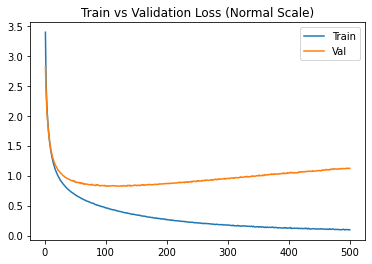

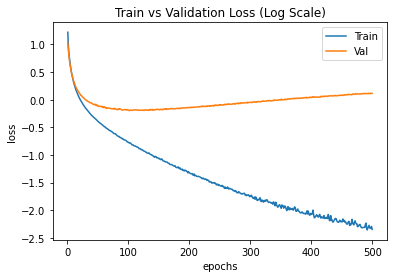

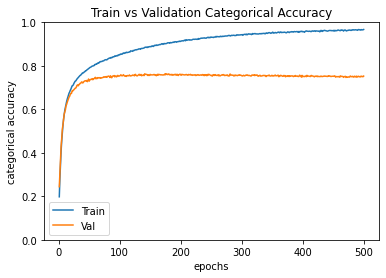

602/602 [==============================] - 1s 1ms/step - loss: 1.0202 - categorical_accuracy: 0.7452 - precision_3: 0.7814 - recall_3: 0.7259


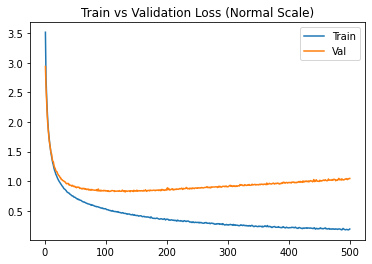

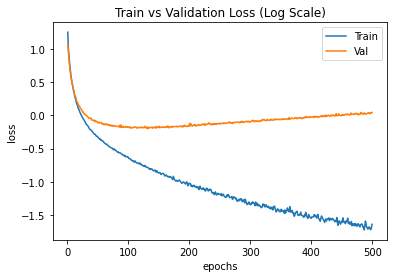

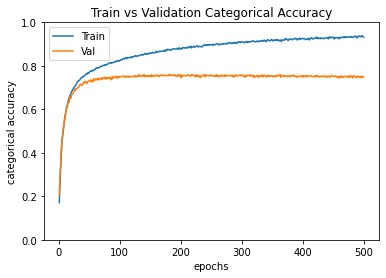

602/602 [==============================] - 1s 1ms/step - loss: 0.9794 - categorical_accuracy: 0.7569 - precision_4: 0.7898 - recall_4: 0.7402


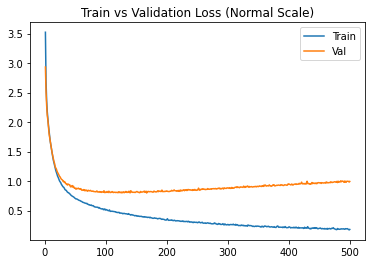

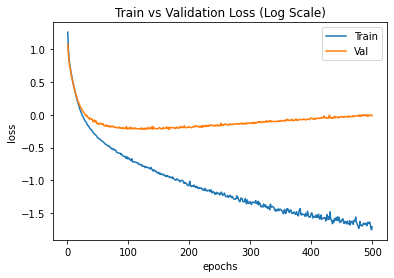

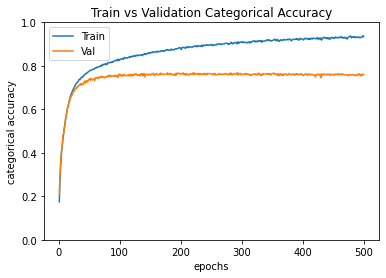

602/602 [==============================] - 1s 1ms/step - loss: 1.1563 - categorical_accuracy: 0.7559 - precision_5: 0.7754 - recall_5: 0.7455


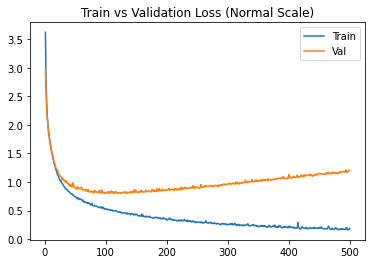

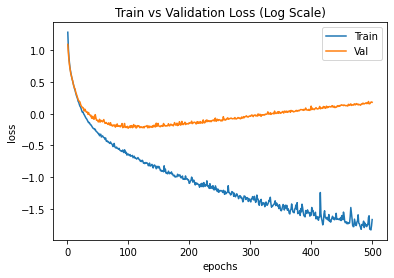

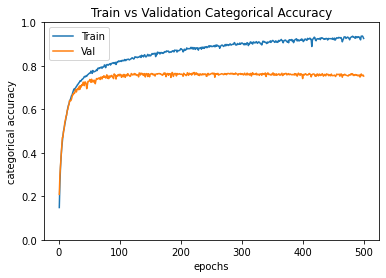

602/602 [==============================] - 1s 1ms/step - loss: 1.1510 - categorical_accuracy: 0.7569 - precision_6: 0.7791 - recall_6: 0.7440


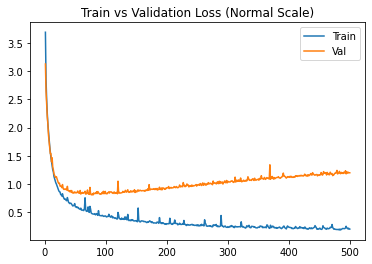

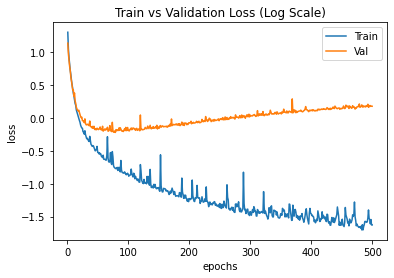

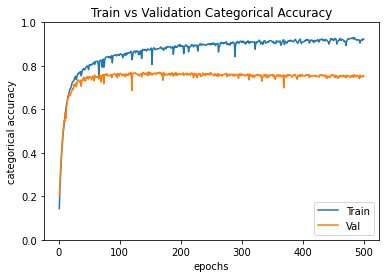

602/602 [==============================] - 1s 1ms/step - loss: 1.1144 - categorical_accuracy: 0.7560 - precision_7: 0.7801 - recall_7: 0.7406


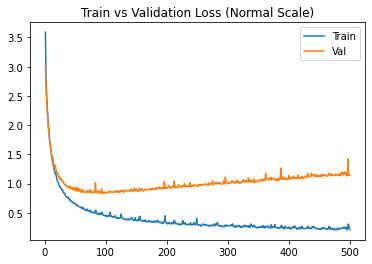

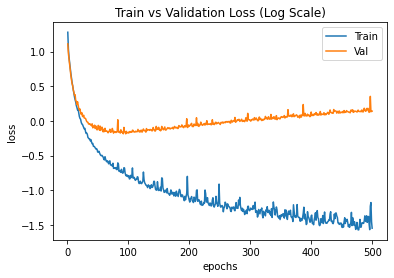

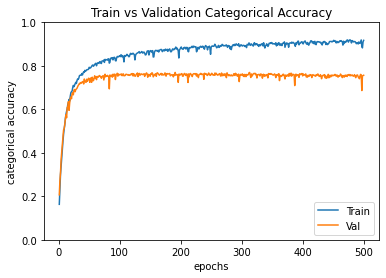

602/602 [==============================] - 1s 1ms/step - loss: 1.0965 - categorical_accuracy: 0.7512 - precision_8: 0.7769 - recall_8: 0.7396


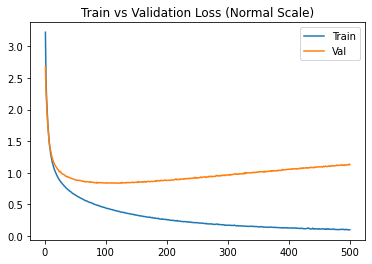

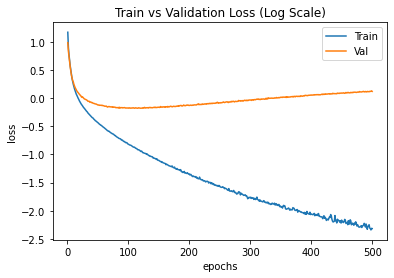

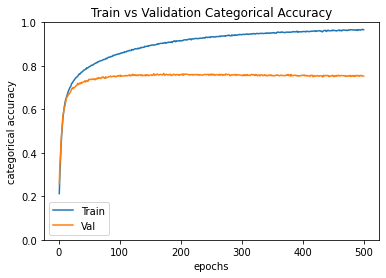

602/602 [==============================] - 1s 1ms/step - loss: 1.0988 - categorical_accuracy: 0.7535 - precision_9: 0.7771 - recall_9: 0.7410


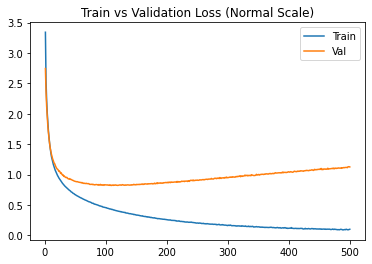

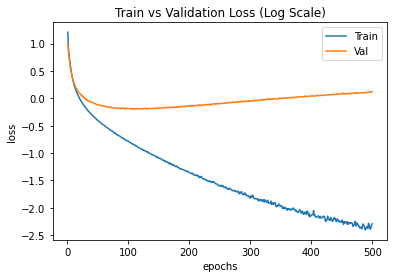

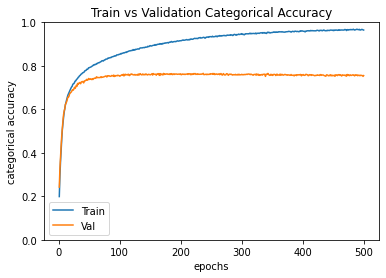

602/602 [==============================] - 1s 1ms/step - loss: 1.1369 - categorical_accuracy: 0.7606 - precision_10: 0.7796 - recall_10: 0.7514


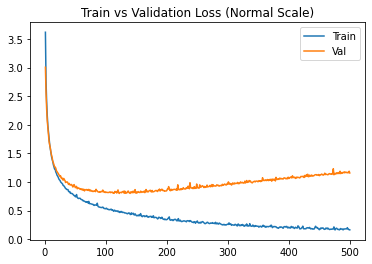

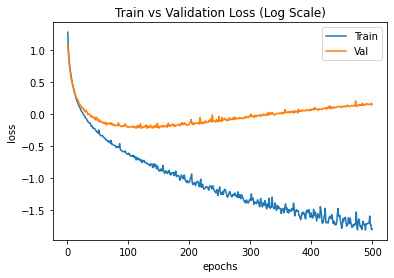

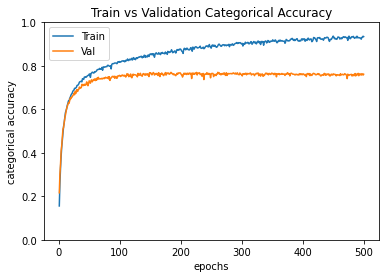

602/602 [==============================] - 1s 1ms/step - loss: 1.4481 - categorical_accuracy: 0.7504 - precision_11: 0.7655 - recall_11: 0.7423


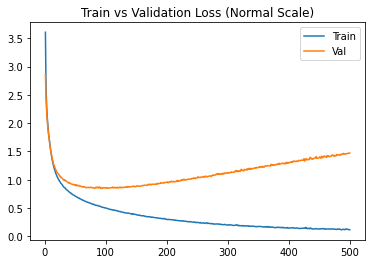

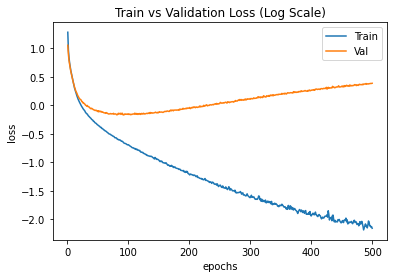

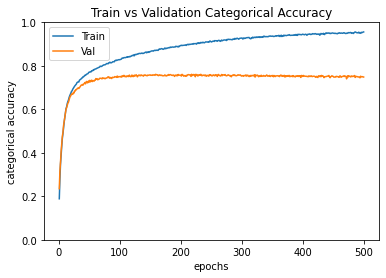

In [81]:
from sklearn.metrics import confusion_matrix
import os 

os.makedirs('img', exist_ok=True)
def evaluate(model,history):
    # evaluate model 
    loss, cat_acc, prec, rec = model.evaluate(X_test_enc, y_test)

    # reshape target data 
    y_pred = model.predict(X_test_enc)
    y_pred = np.argmax(y_pred, axis=1)
    y_test_l = np.argmax(y_test, axis=1)
    
    # place data in a dataframe for easy pretty
    act_vs_pred = pd.DataFrame({'Actual': y_test_l, 'Predicted': y_pred})
#     display(act_vs_pred)

    cm = plt.cm.get_cmap('RdYlBu_r')


    plt.title(f'Train vs Validation Loss (Normal Scale)')
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    x_range = np.arange(1, len(loss_train) + 1)
    plt.plot(x_range, loss_train, label='Train')
    plt.plot(x_range, loss_val, label='Val')
    plt.legend()
    plt.show()
    
    
    plt.title(f'Train vs Validation Loss (Log Scale)')
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    x_range = np.arange(1, len(loss_train) + 1)
    plt.plot(x_range, np.log(loss_train), label='Train')
    plt.plot(x_range, np.log(loss_val), label='Val')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
#     plt.savefig('img/train_vs_val_loss_log.png')
    plt.show()

    plt.title(f'Train vs Validation Categorical Accuracy')
    acc_train = history.history['categorical_accuracy']
    acc_val = history.history['val_categorical_accuracy']
    x_range = np.arange(1, len(acc_train) + 1)
    plt.plot(x_range, acc_train, label='Train')
    plt.plot(x_range, acc_val, label='Val')
    plt.ylim([0,1])
    plt.xlabel('epochs')
    plt.ylabel('categorical accuracy')
    plt.legend()
#     plt.savefig('img/train_vs_val_categorical_accuracy.png')
    plt.show()
    return loss, cat_acc, prec, rec
for model, history in models:
    evaluate(model, history)
# evaluate(models[8][0], models[8][1])
# best models: 8, 4, 6
# print(models[8][1].history['categorical_accuracy'])


In [61]:
labels = ['loss', 'categorical accuracy', 'precision', 'recall']
r1 = list(evaluate(models[8][0], models[8][1]))
r2 = list(evaluate(models[2][0], models[2][1]))
r3 = list(evaluate(models[4][0], models[4][1]))
df = pd.DataFrame([r1,r2,r3], columns=labels)
cols = df.columns.tolist()
cols = [cols[1] ,cols[0]] + cols[2:] 

602/602 [==============================] - 1s 1ms/step - loss: 1.1510 - categorical_accuracy: 0.7569 - precision_6: 0.7791 - recall_6: 0.7440


In [64]:
display(df[cols])

,categorical accuracy,loss,precision,recall
0,0.760551,1.136896,0.779563,0.751403
1,0.756913,0.979351,0.789818,0.740229
2,0.756913,1.150967,0.779090,0.744023



# 5. Future Work:
- Describe what could follow your work.


# 6. Contributions:
- Describe the contributions of each team member.